In [32]:
import pandas as pd
import re
import spacy
import numpy as np
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spacy.tokens import DocBin
from tqdm import tqdm

In [33]:
# Load data
df = pd.read_csv("../data/raw/linkedin_jobs.csv")
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,job_title,job_post,job_description,job_function,job_industry
0,Data Scientist (Entry Level),2 weeks ago,"<div class=""show-more-less-html__markup relati...",Information Technology,Staffing and Recruiting
1,Data Scientist Intern ('24),11 hours ago,"<div class=""show-more-less-html__markup relati...",Engineering and Information Technology,Software Development
2,Data Science,5 days ago,"<div class=""show-more-less-html__markup relati...",Engineering and Information Technology,IT Services and IT Consulting
3,Data Scientist,5 hours ago,"<div class=""show-more-less-html__markup relati...",Information Technology,"Technology, Information and Internet"
4,Data Scientist,1 week ago,"<div class=""show-more-less-html__markup relati...","Information Technology, Business Development, ...","Transportation, Logistics, Supply Chain and St..."


In [6]:
# Load spaCy 
nlp = spacy.load("en_core_web_lg")
# disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ['tokenizer', 'tagger', 'attribute_ruler']]
# for pipe in disabled_pipes:
#     nlp.disable_pipe(pipe)

# Text Preprocessing
# 1. Remove Stop Words and Punctuations
def preprocess_job_desc(text):
    text = re.sub("<[^>]+>", " ", text)  # remove html element tags
    text = re.sub("[ ]+", " ", text)  # remove long spaces
    text = re.sub("[^\u0000-\u007F]+", "", text)  # remove unicode characters/ non ASCII characters
    text = text.lower()  # transform to lower case
    text = text.strip()
    doc = nlp(text)
    return " ".join([word.text for word in doc])

texts = []
for i, row in tqdm(df.iterrows()):
    texts.append(preprocess_job_desc(row['job_description'])+"\n")


with open("../data/interim/jobs.txt", "w") as f:
    f.writelines(texts)

214it [00:18, 11.44it/s]


Prepare Train, Dev and Test Data

In [34]:
# Open the annotations
with open("../data/interim/20240213_annotations.json", "r") as f:
    annotations_json = json.load(f)

# Set params for random select data
total_size = len(annotations_json['annotations'])
train_len, dev_len, test_len = int(total_size * 0.8), int(total_size * 0.1), int(total_size * 0.1) 
data = []
for aj in annotations_json['annotations']:
    data.append((aj[0], aj[1]))    
indexes = np.arange(total_size)
np.random.shuffle(indexes)

# Prepare Train Data
train_data = data[:train_len] 
nlp = spacy.blank('en')
db = DocBin()
for text, annotations in train_data:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations['entities']:
        span = doc.char_span(start, end, label=label)
        if type(span) is not type(None):
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("../data/processed/train.spacy")

# Prepare Dev Data
dev_data = data[train_len : train_len + dev_len] 
nlp = spacy.blank('en')
db = DocBin()
for text, annotations in dev_data:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations['entities']:
        span = doc.char_span(start, end, label=label)
        if type(span) is not type(None):
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("../data/processed/dev.spacy")

# Prepare Test Data
test_data = data[train_len + dev_len : train_len + dev_len + test_len] 
nlp = spacy.blank('en')
db = DocBin()
for text, annotations in test_data:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations['entities']:
        span = doc.char_span(start, end, label=label)
        if type(span) is not type(None):
            ents.append(span)
    doc.ents = ents
    db.add(doc)
db.to_disk("../data/processed/test.spacy")

# Train Model (From Scratch)

In [9]:
# !python -m spacy init fill-config ../config/base_config.cfg ../config/config.cfg
# !python -m spacy train ../config/config.cfg --output ../models --paths.train ../data/processed/train.spacy --paths.dev ../data/processed/dev.spacy

# Test Model

In [35]:
# Load spaCy 
nlp = spacy.load("en_core_web_lg")
disabled_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ['tokenizer', 'tagger', 'attribute_ruler']]
for pipe in disabled_pipes:
    nlp.disable_pipe(pipe)

# Load the Test Data
test_data = DocBin().from_disk("../data/processed/test.spacy")
test_data.__len__()

# Access the Test Data and load Spacy Model
best_model = spacy.load("../models/model-best")
i = 0
hard_skills = []
soft_skills = []
for doc in test_data.get_docs(nlp.vocab):
    docs = best_model(doc.text)
    for doc in docs.ents:
        if doc.label_ == "HARD SKILL":
            hard_skills.append(doc.text)
        elif doc.label_ == "SOFT SKILL":
            soft_skills.append(doc.text)

# Word Cloud 

Hard Skills

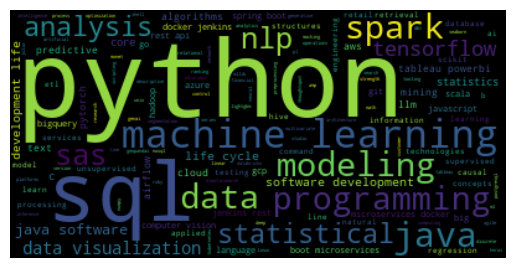

In [36]:
# join the list and lowercase all the words
text = ', '.join(hard_skills).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

Soft Skills

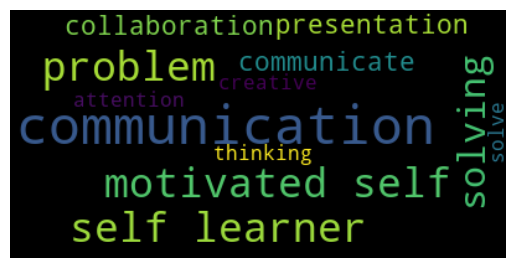

In [37]:
# join the list and lowercase all the words
text = ', '.join(soft_skills).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()